In [ ]:
#!pip install opencv-python-headless
#!pip install efficientnet_pytorch
#!pip install adamp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import Tensor

import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
#from tabulate import tabulate
import seaborn as sns


import skimage.io
from skimage.transform import resize
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
import copy
import multiprocessing


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score


from sklearn.utils import class_weight, shuffle

import warnings
warnings.filterwarnings("ignore")


import efficientnet_pytorch
from tqdm import tqdm
from adamp import AdamP

### 0. Preprocess

* 학습데이터가 각각의 폴더안에 들어있기때문에 쉽게 불러오기 위해 경로를 저장해뒀습니다.

* 다른 파일에서 진행했기때문에 전처리 완료된 파일을 train.csv, test.csv 로 저장했습니다.

In [ ]:
import os
file_list = os.listdir('/content/drive/MyDrive/programmers/data/train/train')

print(len(file_list))
print(file_list)
file_list

In [ ]:
import glob
import pandas as pd
train_list = [file for file in glob.iglob('/content/drive/MyDrive/programmers/data/train/train/**/*.jpg')]
train_list = pd.DataFrame(train_list,columns = ['file_path'])
train_list['label'] = train_list['file_path'].map(lambda x: x.split('/')[-2])
train_list['id'] = train_list['file_path'].map(lambda x: '/'.join(x.split('/')[-2:]).split('.')[0])
train_list.drop('file_path',axis = 1,inplace = True)
train_list.to_csv('/content/drive/MyDrive/programmers/data/train.csv',index = False)

In [ ]:
test_list = [file for file in glob.iglob('/content/drive/MyDrive/programmers/data/test/test/**/*.jpg')]
test_list = pd.DataFrame(test_list,columns = ['file_path'])
test_list['id'] = test_list['file_path'].map(lambda x: '/'.join(x.split('/')[-2:]).split('.')[0])
test_list.drop('file_path',axis = 1,inplace = True)
test_list.to_csv('/content/drive/MyDrive/programmers/data/test.csv',index = False)

### 1.train data

데이터 분포 파악 및 라벨 인코딩

* 이미지 분류 테스크를 수행하기 위해 라벨을 살펴봤습니다.

* horse, guitar 등이 조금 부족하지만 데이터의 수가 너무 많이 부족하진 않다고 판단해 그대로 진행했습니다.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/programmers/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/programmers/data/test.csv')
train_dir = '/content/drive/MyDrive/programmers/data/train/train'
test_dir = '/content/drive/MyDrive/programmers/data/test/test'

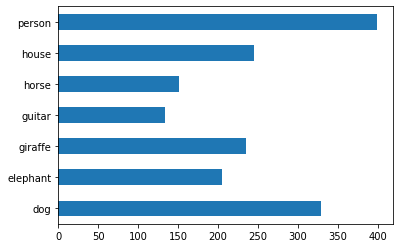

In [ ]:
train['label'].value_counts().sort_index(0).plot.barh()

In [ ]:
def name2label(x):
    if x == 'dog':
        return 0
    elif x =='elephant':
        return 1
    elif x == 'giraffe':
        return 2
    elif x == 'guitar':
        return 3
    elif x == 'horse':
        return 4
    elif x == 'house':
        return 5
    elif x == 'person':
        return 6

In [ ]:
train.label = train.label.map(lambda x: name2label(x))

In [ ]:
train['file_path'] = train.id.map(lambda x: train_dir+'/'+ x +'.jpg')

In [ ]:
test['file_path'] = test.id.map(lambda x: test_dir+'/'+ x +'.jpg')

In [ ]:
train.head()

,label,id,file_path
0,5,house/pic_248,/content/drive/MyDrive/programmers/data/train/...
1,5,house/pic_247,/content/drive/MyDrive/programmers/data/train/...
2,5,house/pic_245,/content/drive/MyDrive/programmers/data/train/...
3,5,house/pic_243,/content/drive/MyDrive/programmers/data/train/...
4,5,house/pic_241,/content/drive/MyDrive/programmers/data/train/...


In [ ]:
x = train.id
y = train.label

skf = StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
train['fold'] = -1
for i,(trn_idx,vld_idx) in enumerate(skf.split(x,y)):
    train.loc[vld_idx,'fold'] = i
train['fold'].value_counts()

2    340
1    340
0    340
4    339
3    339
Name: fold, dtype: int64

### 3. Dataset

데이터 형태 파악

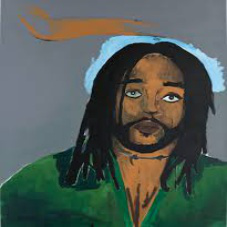

In [ ]:
num = np.random.randint(len(train))
a = Image.open(train_dir+'/'+train.loc[num,'id']+'.jpg')
a

In [ ]:
a_np = np.array(a)
a_np.shape

(227, 227, 3)

### 4. Image Dataset 생성

모델이 더 다양한 데이터를 학습할 수 있게 Augmentation을 적용해줬습니다.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame,mode):
        self.df = dataframe
        self.file_paths = dataframe['file_path'].values
        self.mode = mode
        transforms_list = []
        
        if self.mode =='train':
            transforms_list = [
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomResizedCrop(224),
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
            ]

        else:
            transforms_list.extend([
                # Keep this resize same as train
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
            ])
        self.transforms = transforms.Compose(transforms_list)


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index: int):
        if self.mode =='inference':
            image_id = self.df.iloc[index].id
            image_path = self.file_paths[index]
            image = Image.open(image_path)
            image = self.transforms(image)

        else:
            image_id = self.df.iloc[index].id
            image_path = self.file_paths[index]
            image = Image.open(image_path)
            image = self.transforms(image)
            label = self.df.iloc[index].label

        if self.mode =='inference':
            return image
        
        else:
            #label = self.df.iloc[index]['label']            
            return image, label

### 5.training

* 앙상블을 위해 각 fold 별로 데이터셋 생성

* 앙상블 이유 : 학습 데이터가 2000개에 못 미치므로 validation을 위해 나눈 validation set을 학습하지 않는 것이 아깝다 생각했습니다.


* 그래서 5-fold를 이용해 5번의 학습으로 데이터 셋을 골고루 학습할 수 있게 도왔습니다.



* 모델 : Efficientnet-b3

* 최적의 파라미터로 최대의 효율을 내는 Efficientnet을 모델로 썼습니다.

* 또한, 모델의 pretrained 데이터 셋이 imagenet으로 다양한 class에 대한 분류를 학습했기 때문에 선택했습니다.


In [ ]:
all_logits = []


for fold in range(5):
    #dataloader
    trn_idx = train[train['fold'] != fold].index
    vld_idx = train[train['fold'] == fold].index
    trn_dataset = ImageDataset(train.loc[trn_idx],
                            'train')

    vld_dataset =  ImageDataset(train.loc[vld_idx],
                                'valid')
    num_workers = 0
    trn_loader = DataLoader(trn_dataset,
                        shuffle = True,
                        num_workers = num_workers,
                        batch_size = 32)
    vld_loader = DataLoader(vld_dataset,
                        shuffle = False,
                        num_workers = num_workers,
                        batch_size = 32)


    #model/optimizer/criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained('efficientnet-b3')
    input_size = model._fc.in_features
    model._fc = nn.Linear(input_size,out_features = train.label.nunique(),bias = True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    #optimizer = AdamP(model.parameters(), lr=0.0000003, betas=(0.9, 0.999), weight_decay=1e-2)
    #optimizer = AdamP(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-2)

    criterion = nn.CrossEntropyLoss()
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



    epochs = 30
    best_score = 0 
    cnt=0

    for epoch in range(epochs):
        print('Epoch:',epoch)
        train_loss = []
        model.train()
        for inputs, targets in tqdm(trn_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            
            loss = criterion(logits,targets)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())

        val_loss = []
        val_true = []
        val_pred = []

        model.eval()
        

        # gradient를 건들지 않겠다.
        with torch.no_grad():
            for inputs, targets in tqdm(vld_loader):
            # gpu사용시
                inputs = inputs.cuda()
                targets = targets.cuda()
                logits = model(inputs)

                loss = criterion(logits,targets)
                val_loss.append(loss.item())

                pred =logits.cpu().argmax(dim=1).data.numpy()
                
                val_true.append(targets.cpu().numpy())
                val_pred.append(pred)

        val_true = np.concatenate(val_true)
        val_pred = np.concatenate(val_pred)
        val_loss = np.mean(val_loss)
        train_loss = np.mean(train_loss)
        
        val_f1 = f1_score(val_true,val_pred,average = 'macro')
        val_acc = accuracy_score(val_true,val_pred)
        
        print('val_f1 :',val_f1,'val_acc :',val_acc,'train_loss :',train_loss,'valid_loss :',val_loss)
        

        if val_f1 > best_score:
            cnt=0
            best_score = val_f1
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights,'/content/drive/MyDrive/programmers/e3_fold'+str(fold)+'best.path')
        
        else:
            cnt+=1
            if cnt == 3:
                print('Early Stop:',epoch)
                break

cuda
Loaded pretrained weights for efficientnet-b3


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 0


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.23837506471403458 val_acc : 0.25882352941176473 train_loss : 1.9607347859892734 valid_loss : 1.8880311250686646


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.4310317165156121 val_acc : 0.45588235294117646 train_loss : 1.8888068864511889 valid_loss : 1.8049768209457397


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.573280937574078 val_acc : 0.6 train_loss : 1.8077598560688108 valid_loss : 1.7221314907073975


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.6497922559205495 val_acc : 0.6735294117647059 train_loss : 1.7313359060952829 valid_loss : 1.636510816487399


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.7233565075322123 val_acc : 0.7470588235294118 train_loss : 1.6582786621049392 valid_loss : 1.5444457530975342


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.7759449009654096 val_acc : 0.7970588235294118 train_loss : 1.5693101605703665 valid_loss : 1.4419206164099954


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.811959287124541 val_acc : 0.8294117647058824 train_loss : 1.465907288152118 valid_loss : 1.3246725797653198


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.8335014564515403 val_acc : 0.8470588235294118 train_loss : 1.369168614232263 valid_loss : 1.2014562433416194


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.8634265921975784 val_acc : 0.8735294117647059 train_loss : 1.2489467193914014 valid_loss : 1.0733003507960925


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.8806026667163469 val_acc : 0.8911764705882353 train_loss : 1.1485716950061708 valid_loss : 0.9524707198143005


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.8868248404986553 val_acc : 0.8970588235294118 train_loss : 1.051393399404925 valid_loss : 0.8452263826673682


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.9060513728289373 val_acc : 0.9117647058823529 train_loss : 0.955010824425276 valid_loss : 0.7497947988185015


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12


100%|██████████| 11/11 [00:02<00:00,  4.95it/s]


val_f1 : 0.9142046399935921 val_acc : 0.9176470588235294 train_loss : 0.88112258356671 valid_loss : 0.6706034554676576


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13


100%|██████████| 11/11 [00:02<00:00,  4.78it/s]


val_f1 : 0.9358441653230646 val_acc : 0.9352941176470588 train_loss : 0.7985911521800729 valid_loss : 0.6068424812772057


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14


100%|██████████| 11/11 [00:02<00:00,  4.95it/s]


val_f1 : 0.9443833263390913 val_acc : 0.9441176470588235 train_loss : 0.7370948611303817 valid_loss : 0.5531114326281981


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9430079008496851 val_acc : 0.9411764705882353 train_loss : 0.6847190822279731 valid_loss : 0.5031177428635684
Epoch: 16


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.9457859059673941 val_acc : 0.9441176470588235 train_loss : 0.602143584988838 valid_loss : 0.4617345373738896


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9530368472690826 val_acc : 0.9529411764705882 train_loss : 0.5789024774418321 valid_loss : 0.4249087782068686


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9537078561322343 val_acc : 0.9529411764705882 train_loss : 0.5544565091299456 valid_loss : 0.3932133838534355


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.9578503761498682 val_acc : 0.9558823529411765 train_loss : 0.4959204626637836 valid_loss : 0.36672849411314185


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9571793672867163 val_acc : 0.9558823529411765 train_loss : 0.4646780629490697 valid_loss : 0.3399963913993402
Epoch: 21


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9578503761498682 val_acc : 0.9558823529411765 train_loss : 0.43000237609064856 valid_loss : 0.316685865548524
Epoch: 22


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.9586946901533496 val_acc : 0.9588235294117647 train_loss : 0.4368931976861732 valid_loss : 0.29643695666031405


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.9607153049314014 val_acc : 0.961764705882353 train_loss : 0.3766141804151757 valid_loss : 0.2803781635381959


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9607153049314014 val_acc : 0.961764705882353 train_loss : 0.37547034614307934 valid_loss : 0.2664437724108046
Epoch: 25


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9633562498565962 val_acc : 0.9647058823529412 train_loss : 0.34068590575872465 valid_loss : 0.2539710615846244


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9597975185028338 val_acc : 0.961764705882353 train_loss : 0.33604351864304655 valid_loss : 0.24517748471010814
Epoch: 27


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.954624528408745 val_acc : 0.9588235294117647 train_loss : 0.32559424014978633 valid_loss : 0.2327532565051859
Epoch: 28


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.954624528408745 val_acc : 0.9588235294117647 train_loss : 0.2905541873255441 valid_loss : 0.2218950759958137
Early Stop: 28


100%|██████████| 22/22 [00:02<00:00,  9.18it/s]


cuda


  0%|          | 0/43 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3
Epoch: 0


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.2602591394269182 val_acc : 0.31176470588235294 train_loss : 1.9200130867403606 valid_loss : 1.8433443091132424


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 11/11 [00:02<00:00,  4.97it/s]


val_f1 : 0.4153800258556026 val_acc : 0.4852941176470588 train_loss : 1.8468823599260906 valid_loss : 1.7665505842729048


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.5425830061277859 val_acc : 0.6058823529411764 train_loss : 1.769912974778996 valid_loss : 1.6879884221337058


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.6466041156558242 val_acc : 0.7058823529411765 train_loss : 1.692629755929459 valid_loss : 1.6074189706282183


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.720800215120214 val_acc : 0.7617647058823529 train_loss : 1.6090527966965076 valid_loss : 1.5186792828819968


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.7585412676768838 val_acc : 0.7911764705882353 train_loss : 1.513748002606769 valid_loss : 1.4159832759336992


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6


100%|██████████| 11/11 [00:02<00:00,  4.85it/s]


val_f1 : 0.7917951230785699 val_acc : 0.8147058823529412 train_loss : 1.4172633082367654 valid_loss : 1.3039599006826228


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.8182684608017903 val_acc : 0.8382352941176471 train_loss : 1.3124229630758597 valid_loss : 1.182749937881123


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.8444170573928524 val_acc : 0.8588235294117647 train_loss : 1.1929207485775615 valid_loss : 1.0620740408247167


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.8686051110237891 val_acc : 0.8794117647058823 train_loss : 1.0763885614483855 valid_loss : 0.947730235078118


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.8818732331008913 val_acc : 0.888235294117647 train_loss : 0.9988085156263307 valid_loss : 0.8505837944420901


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11


100%|██████████| 11/11 [00:02<00:00,  4.85it/s]


val_f1 : 0.8967801289344829 val_acc : 0.9029411764705882 train_loss : 0.9024758172589679 valid_loss : 0.7576132416725159


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.9031969477771788 val_acc : 0.9088235294117647 train_loss : 0.8440181682276171 valid_loss : 0.6821845295754346


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9017442952867405 val_acc : 0.9088235294117647 train_loss : 0.7604961755663849 valid_loss : 0.617051973938942
Epoch: 14


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9141306508842739 val_acc : 0.9205882352941176 train_loss : 0.7020813559376916 valid_loss : 0.5598543164404955


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.9181327325912737 val_acc : 0.9235294117647059 train_loss : 0.6398564355317936 valid_loss : 0.5145505693825808


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.9234948362930844 val_acc : 0.9294117647058824 train_loss : 0.5678253908490025 valid_loss : 0.4710974476554177


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9228531180356276 val_acc : 0.9294117647058824 train_loss : 0.5613865810771321 valid_loss : 0.4334717081351714
Epoch: 18


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9228531180356276 val_acc : 0.9294117647058824 train_loss : 0.5089656260124472 valid_loss : 0.4001681018959392
Epoch: 19


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.926989722172232 val_acc : 0.9323529411764706 train_loss : 0.4610844885194024 valid_loss : 0.37125477668913925


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20


100%|██████████| 11/11 [00:02<00:00,  4.81it/s]


val_f1 : 0.9301680474017867 val_acc : 0.9352941176470588 train_loss : 0.4420383038908936 valid_loss : 0.345302205871452


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9264492752353205 val_acc : 0.9323529411764706 train_loss : 0.42912434907846675 valid_loss : 0.32464428516951477
Epoch: 22


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9264492752353205 val_acc : 0.9323529411764706 train_loss : 0.39327232712923094 valid_loss : 0.3074294924736023
Epoch: 23


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9264492752353205 val_acc : 0.9323529411764706 train_loss : 0.35710940458053764 valid_loss : 0.28994211283597077
Early Stop: 23


100%|██████████| 22/22 [00:02<00:00,  9.10it/s]


cuda
Loaded pretrained weights for efficientnet-b3


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 0


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.28414057434019646 val_acc : 0.31176470588235294 train_loss : 1.9225848053776942 valid_loss : 1.8560138073834507


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.4422493189786774 val_acc : 0.4823529411764706 train_loss : 1.8504040573918543 valid_loss : 1.7770387476140803


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 11/11 [00:02<00:00,  4.79it/s]


val_f1 : 0.5403070648800056 val_acc : 0.6 train_loss : 1.7830839295719945 valid_loss : 1.7007581970908425


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.675903447740924 val_acc : 0.7205882352941176 train_loss : 1.7026388894679934 valid_loss : 1.6227841810746626


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.7262730463115147 val_acc : 0.7676470588235295 train_loss : 1.6283632655476414 valid_loss : 1.5341321229934692


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.7682736804858443 val_acc : 0.8 train_loss : 1.5411627043125242 valid_loss : 1.4352918863296509


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6


100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


val_f1 : 0.7858732614539534 val_acc : 0.8176470588235294 train_loss : 1.443978988847067 valid_loss : 1.3246971693905918


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.8284602648623206 val_acc : 0.85 train_loss : 1.3346470954806307 valid_loss : 1.2032951333306052


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.8523620839031668 val_acc : 0.8676470588235294 train_loss : 1.2246592238891956 valid_loss : 1.0766012885353782


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.8661261589173014 val_acc : 0.8794117647058823 train_loss : 1.1278369301973388 valid_loss : 0.9588721719655123


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.8807207226861147 val_acc : 0.8911764705882353 train_loss : 1.0226548161617546 valid_loss : 0.8530848080461676


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.8901662859054497 val_acc : 0.9 train_loss : 0.9229612641556318 valid_loss : 0.76026297157461


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.9149042746026473 val_acc : 0.9205882352941176 train_loss : 0.833512008190155 valid_loss : 0.6842128444801677


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13


100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


val_f1 : 0.9208917109673427 val_acc : 0.9264705882352942 train_loss : 0.7700055615846501 valid_loss : 0.6128057376904921


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9286035356836937 val_acc : 0.9323529411764706 train_loss : 0.6839416997377262 valid_loss : 0.5522427287968722


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.941224550620669 val_acc : 0.9441176470588235 train_loss : 0.653613195862881 valid_loss : 0.5005197511477903


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.940058928088102 val_acc : 0.9441176470588235 train_loss : 0.582105027381764 valid_loss : 0.45979937369173224
Epoch: 17


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val_f1 : 0.9426392425105217 val_acc : 0.9470588235294117 train_loss : 0.5379457556924154 valid_loss : 0.4221829812635075


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.943067475943978 val_acc : 0.9470588235294117 train_loss : 0.5089125265908796 valid_loss : 0.38865830410610547


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9472573670632107 val_acc : 0.95 train_loss : 0.475009445534196 valid_loss : 0.36028899387879804


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9450168174009442 val_acc : 0.95 train_loss : 0.46856560402138286 valid_loss : 0.3352240147915753
Epoch: 21


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9481004920346832 val_acc : 0.9529411764705882 train_loss : 0.4130335204129995 valid_loss : 0.3151632113890214


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.9493705099550687 val_acc : 0.9529411764705882 train_loss : 0.40922889529272566 valid_loss : 0.2954445393248038


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9488076292395162 val_acc : 0.9529411764705882 train_loss : 0.36658666577450066 valid_loss : 0.2773144692182541
Epoch: 24


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9573146986142522 val_acc : 0.9588235294117647 train_loss : 0.3706208706595177 valid_loss : 0.2613995928655971


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9573146986142522 val_acc : 0.9588235294117647 train_loss : 0.3473387086807295 valid_loss : 0.24878558313304727
Epoch: 26


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9573146986142522 val_acc : 0.9588235294117647 train_loss : 0.2917874004951743 valid_loss : 0.23512437330050903
Epoch: 27


100%|██████████| 11/11 [00:02<00:00,  4.82it/s]


val_f1 : 0.9573146986142522 val_acc : 0.9588235294117647 train_loss : 0.30962372813806976 valid_loss : 0.22736110944639554
Early Stop: 27


100%|██████████| 22/22 [00:02<00:00,  9.04it/s]


cuda
Loaded pretrained weights for efficientnet-b3


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 0


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.24886861611140046 val_acc : 0.26253687315634217 train_loss : 1.9470933010411817 valid_loss : 1.892818201671947


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.41659589737622166 val_acc : 0.44542772861356933 train_loss : 1.876974995746169 valid_loss : 1.8161514780738137


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.5111442667606262 val_acc : 0.5457227138643068 train_loss : 1.8001402117485223 valid_loss : 1.7414249615235762


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.5997255309840245 val_acc : 0.6371681415929203 train_loss : 1.731402732605158 valid_loss : 1.6598288796164773


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4


100%|██████████| 11/11 [00:02<00:00,  4.81it/s]


val_f1 : 0.6868330626813792 val_acc : 0.7138643067846607 train_loss : 1.6410099933313769 valid_loss : 1.570497902956876


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.7748865872805932 val_acc : 0.8023598820058997 train_loss : 1.5479446400043577 valid_loss : 1.4677730907093396


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.822145879094018 val_acc : 0.8436578171091446 train_loss : 1.4591062207554661 valid_loss : 1.350462550466711


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.832787750945149 val_acc : 0.8525073746312685 train_loss : 1.361512300580047 valid_loss : 1.2236982800743796


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8


100%|██████████| 11/11 [00:02<00:00,  4.78it/s]


val_f1 : 0.8562363094900142 val_acc : 0.8731563421828908 train_loss : 1.226814441902693 valid_loss : 1.093792275948958


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.8876653760137794 val_acc : 0.8967551622418879 train_loss : 1.135012851204983 valid_loss : 0.9700882136821747


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.8952477636315865 val_acc : 0.9026548672566371 train_loss : 1.0254679876704549 valid_loss : 0.8612474419853904


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.911405007359213 val_acc : 0.9174041297935103 train_loss : 0.9343101382255554 valid_loss : 0.7607344172217629


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9163720863442419 val_acc : 0.9233038348082596 train_loss : 0.850059708883596 valid_loss : 0.6802114925601266


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9169307858587405 val_acc : 0.9233038348082596 train_loss : 0.7787537048029345 valid_loss : 0.6075133234262466


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.917798787512847 val_acc : 0.9233038348082596 train_loss : 0.7230551450751549 valid_loss : 0.5507877956737172


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


val_f1 : 0.9191398363800273 val_acc : 0.9262536873156342 train_loss : 0.6661929363428161 valid_loss : 0.5023552978580649


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9221684678817859 val_acc : 0.9292035398230089 train_loss : 0.5825946532016577 valid_loss : 0.4593985019759698


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.9261092641560581 val_acc : 0.9321533923303835 train_loss : 0.5298013250495113 valid_loss : 0.4214679002761841


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18


100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


val_f1 : 0.9321828362019376 val_acc : 0.9380530973451328 train_loss : 0.52210095247557 valid_loss : 0.39147316122596915


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9316545629056326 val_acc : 0.9380530973451328 train_loss : 0.48000034066133723 valid_loss : 0.3651088171384551
Epoch: 20


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9405164746551301 val_acc : 0.943952802359882 train_loss : 0.4370464540498201 valid_loss : 0.3386486910960891


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9471568971062287 val_acc : 0.9498525073746312 train_loss : 0.41442145233930544 valid_loss : 0.3176204829730771


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9410937609913309 val_acc : 0.943952802359882 train_loss : 0.3803380114394565 valid_loss : 0.29837778820232913
Epoch: 23


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9406202404741907 val_acc : 0.943952802359882 train_loss : 0.3692222684621811 valid_loss : 0.2836721485311335
Epoch: 24


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.9505495243794531 val_acc : 0.9528023598820059 train_loss : 0.3513197992430177 valid_loss : 0.2712089287286455


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9472464092750956 val_acc : 0.9498525073746312 train_loss : 0.33091924668744555 valid_loss : 0.25790553946386685
Epoch: 26


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9438537820018713 val_acc : 0.9469026548672567 train_loss : 0.3335453909496928 valid_loss : 0.24633682349866087
Epoch: 27


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


val_f1 : 0.9438537820018713 val_acc : 0.9469026548672567 train_loss : 0.2902021927889003 valid_loss : 0.23595424030314793
Early Stop: 27


100%|██████████| 22/22 [00:02<00:00,  8.96it/s]


cuda


  0%|          | 0/43 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3
Epoch: 0


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.25423623227417275 val_acc : 0.25958702064896755 train_loss : 1.9591382076573927 valid_loss : 1.8933767405423252


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.42224210623257447 val_acc : 0.4336283185840708 train_loss : 1.8716123325880183 valid_loss : 1.804104577411305


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.5959191473153791 val_acc : 0.6047197640117994 train_loss : 1.7967267895853796 valid_loss : 1.716358488256281


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


val_f1 : 0.7127207972382161 val_acc : 0.7227138643067846 train_loss : 1.7190795166547908 valid_loss : 1.6272556239908391


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4


100%|██████████| 11/11 [00:02<00:00,  4.85it/s]


val_f1 : 0.7684037001101303 val_acc : 0.7787610619469026 train_loss : 1.6219408373500026 valid_loss : 1.5312906828793613


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.7992946846277574 val_acc : 0.8082595870206489 train_loss : 1.5396013842072598 valid_loss : 1.4243537458506497


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.8402434626587315 val_acc : 0.8466076696165191 train_loss : 1.4460755725239598 valid_loss : 1.3063293207775464


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7


100%|██████████| 11/11 [00:02<00:00,  4.85it/s]


val_f1 : 0.8789322475740386 val_acc : 0.8790560471976401 train_loss : 1.3271228407704554 valid_loss : 1.1859728639776057


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8


100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


val_f1 : 0.895117291011769 val_acc : 0.8938053097345132 train_loss : 1.2197582749433296 valid_loss : 1.066941732710058


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9064964828025946 val_acc : 0.9085545722713865 train_loss : 1.115945530492206 valid_loss : 0.9552781581878662


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10


100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


val_f1 : 0.9199383257696928 val_acc : 0.9203539823008849 train_loss : 1.0278346885082335 valid_loss : 0.8513337414373051


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11


100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


val_f1 : 0.9219231909053408 val_acc : 0.9233038348082596 train_loss : 0.9313048664913621 valid_loss : 0.7563796707174995


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


val_f1 : 0.9231856934860927 val_acc : 0.9233038348082596 train_loss : 0.8361513198808183 valid_loss : 0.6769259450110522


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.9326309914114791 val_acc : 0.9321533923303835 train_loss : 0.7923249006271362 valid_loss : 0.6078938665715131


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9463713703280826 val_acc : 0.943952802359882 train_loss : 0.7126686836397925 valid_loss : 0.5472461703148755


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15


100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


val_f1 : 0.9497707969588431 val_acc : 0.9469026548672567 train_loss : 0.6605039114175841 valid_loss : 0.49831983040679584


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16


100%|██████████| 11/11 [00:02<00:00,  4.81it/s]


val_f1 : 0.9542106616798661 val_acc : 0.9498525073746312 train_loss : 0.5950474856897842 valid_loss : 0.45341782339594583


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9542106616798661 val_acc : 0.9498525073746312 train_loss : 0.5488708123218181 valid_loss : 0.4162346761335026
Epoch: 18


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val_f1 : 0.9574271208494702 val_acc : 0.9528023598820059 train_loss : 0.509014765883601 valid_loss : 0.3808313899419524


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9593791526920541 val_acc : 0.9557522123893806 train_loss : 0.48822349448536717 valid_loss : 0.35275548561052844


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


val_f1 : 0.9620128592059887 val_acc : 0.9587020648967551 train_loss : 0.45666291478068327 valid_loss : 0.3268961540677331


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21


100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


val_f1 : 0.963018252224671 val_acc : 0.9616519174041298 train_loss : 0.4178716672021289 valid_loss : 0.30361352183602075


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9650586007163138 val_acc : 0.9646017699115044 train_loss : 0.4226924111676771 valid_loss : 0.2851432433182543


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


val_f1 : 0.9684761087269127 val_acc : 0.967551622418879 train_loss : 0.38174860144770423 valid_loss : 0.2681557515805418


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val_f1 : 0.9736646526056937 val_acc : 0.9734513274336283 train_loss : 0.3286373535561007 valid_loss : 0.25176761231639166


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9736646526056937 val_acc : 0.9734513274336283 train_loss : 0.32756165467029397 valid_loss : 0.23608594150705772
Epoch: 26


  0%|          | 0/43 [00:00<?, ?it/s]

val_f1 : 0.9702639217111085 val_acc : 0.9705014749262537 train_loss : 0.3268959698982017 valid_loss : 0.2238232164897702
Epoch: 27


100%|██████████| 11/11 [00:02<00:00,  4.65it/s]


val_f1 : 0.9702639217111085 val_acc : 0.9705014749262537 train_loss : 0.2948210939418438 valid_loss : 0.2124780568886887
Early Stop: 27


100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


## 6.Inference

In [ ]:
all_logits = []
#inference
for fold in range(5):
    eval = test.sort_values(by = 'id')

    tst_dataset = ImageDataset(eval,'inference')
    tst_loader = DataLoader(tst_dataset,
                        shuffle = False,
                        num_workers = 0,
                        batch_size = 16)

    model.load_state_dict(torch.load('/content/drive/MyDrive/programmers/e3_fold'+str(fold)+'best.path'))
    model.eval()
    
    predicts = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(tst_loader)):
            data = data.cuda()
            logits = model(data).cpu().numpy()
            
            predicts.append(logits)
    
    predicts = list(np.concatenate(predicts))

    all_logits.append(predicts)


100%|██████████| 22/22 [00:02<00:00,  9.18it/s]


### 7. Ensemble

In [ ]:
answer = np.array(all_logits[0])
for i in range(1,5):
    answer += np.array(all_logits[i])

In [ ]:
len(answer)

350

In [ ]:
answer = answer.argmax(1)

In [ ]:
sample_data = pd.read_csv('/content/drive/MyDrive/programmers/data/test_answer_sample.csv')
sample_data['answer value'] = answer
sample_data['answer value'].to_csv('/content/drive/MyDrive/programmers/data/ensemble.csv')